# Environment

### Downloads

In [ ]:
!pip install gym
!pip install "stable-baselines3[extra]>=2.0.0a4"

### Imports

In [2]:
import gym
from gym import Env, spaces
import numpy as np
from stable_baselines3 import PPO

# Utilidad
import json
import copy # Para copiar las variables originales a las que el ambiente edite para cuando se haga un reset
import random

2024-09-09 21:33:44.152616: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-09 21:33:44.189733: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-09 21:33:44.831117: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Funciones útiles

### Definición

In [9]:
preferencias = [
    [1,2,3,0],
    [0,3,2,1],
    [3,2,1,0]
]

state = [
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0]
]

observation = [
    preferencias, state
]

In [3]:
class OrganizationEnvironment(gym.Env):
    def __init__(self, preferencias = None, rendering = False):
        super(OrganizationEnvironment, self).__init__()

        self.all_rewards = []
        self.rendering = rendering

        if(preferencias == None):
            self.preferencias = self.get_preferencias()
        else:
            self.preferencias = preferencias

        self.num_estudiantes = len(self.preferencias)
        self.num_desafios = len(self.preferencias[0])

        self.num_preferencias = 0
        for i in self.preferencias:
            for j in i:
                if j > self.num_preferencias:
                    self.num_preferencias = j


        self.state = [[ 0 for _ in range(self.num_desafios)] for _ in range(self.num_estudiantes)]
        self.current_ids = list(range(len(self.preferencias)))
        self.reset()

        # Definición de espacio de observación
        self.observation_space = spaces.MultiDiscrete([2] * (self.num_estudiantes * self.num_desafios) + \
                                                      [self.num_desafios] * (self.num_estudiantes * self.num_desafios))
        # Definición de espacio de acción
        self.action_space = spaces.MultiDiscrete([self.num_estudiantes, self.num_desafios])


    def get_preferencias(self):
        num_estudiantes = 10
        num_desafios = 4

        preferencias_totales = []

        for i in range(num_estudiantes):
            preferencias_estudiante = [0] * (num_desafios)
            numero_preferencia = 1

            while True:
                desafio = random.randint(0, num_desafios - 1)
                if(preferencias_estudiante[desafio] == 0):
                    preferencias_estudiante[desafio] = numero_preferencia
                    numero_preferencia += 1
                if(numero_preferencia > 3):
                    break
            preferencias_totales.append(preferencias_estudiante)

        if(self.rendering):
            print("\t  Preferencias")
            for index, fila in enumerate(preferencias_totales):
                print(f"Alumno {index}: ",fila)

        return preferencias_totales

    def render(self):
        print("\t  Desafíos")
        for index, fila in enumerate(self.state):
            print(f"Alumno {index}: ",fila)

    def reset(self):

        last_observation = self._get_observation()

        self.lives = 3
        self
        self.preferencias = self.get_preferencias()
        self.reward_acumulado = 0
        self.num_estudiantes = len(self.preferencias)
        self.num_desafios = len(self.preferencias[0])

        self.num_preferencias = 0
        for i in self.preferencias:
            for j in i:
                if j > self.num_preferencias:
                    self.num_preferencias = j


        # Espacio de observación
        self.state = [[ 0 for _ in range(self.num_desafios)] for _ in range(self.num_estudiantes)]
        self.current_ids = list(range(len(self.preferencias)))

        return last_observation

    def step(self, action):
        assert self.action_space.contains(action), "Invalid Action"

        id_estudiante = action[0]
        id_desafio = action[1]

        done = self.check_done()

        if self._chech_possible(id_estudiante, id_desafio):

            self.state[id_estudiante][id_desafio] = 1

            if(not done):
                contador_escogidos = 0
                for estudiante in self.state:
                    for desafio in estudiante:
                        contador_escogidos += desafio

            reward = self.get_reward([id_estudiante, id_desafio])

        else:
            self.lives -= 1
            reward = -8

        self.reward_acumulado += reward
        if not(self.lives > 0):
            done = True
        # observation = [self.state, self.preferencias]
        observation = self._get_observation()
        info = {}

        if done:
            self.all_rewards.append(self.reward_acumulado)
            return observation, self.reward_acumulado, done, info
        return observation, reward, done, info


    def _chech_possible(self, id_estudiante, id_desafio):
        # Ver si el estudiante ya esta dentro de un desafío
        total_desafios_asignados = 0
        for desafio_estudiante in self.state[id_estudiante]:
            total_desafios_asignados += desafio_estudiante
        if(total_desafios_asignados > 0):
            return False

        return True

    def _get_observation(self):
        # Aplanar el estado y las preferencias para ajustarse al espacio de observación
        return [self.state[i][j] for i in range(self.num_estudiantes) for j in range(self.num_desafios)] + \
               [self.preferencias[i][j] for i in range(self.num_estudiantes) for j in range(self.num_desafios)]

    def get_reward(self, action):
        id_estudiante = action[0]
        id_desafio = action[1]

        reward = 0
        # Reward por las preferencias
        reward +=   (self.num_preferencias - self.preferencias[id_estudiante][id_desafio] + 1) * 2 \
                    if self.preferencias[id_estudiante][id_desafio] != 0 \
                    else -5


        # Reward

        # Implementar función de reward
        return reward

    def check_done(self):
        # Condición para finalizar el episodio
        contador_de_estudiantes = 0
        for estudiante in self.state:
            for seleccion in estudiante:
                contador_de_estudiantes += seleccion

        if(contador_de_estudiantes == self.num_estudiantes):
            return True

        return False

env = OrganizationEnvironment()

In [18]:
env.reset()
while True:
    action = env.action_space.sample()

    obs, reward, done, info = env.step(action)

    env.render()

    if done == True:
        break

# print(binary_to_dict2(obs))

	  Desafíos
Alumno 0:  [0, 0, 0, 0]
Alumno 1:  [0, 0, 1, 0]
Alumno 2:  [0, 0, 0, 0]
Alumno 3:  [0, 0, 0, 0]
Alumno 4:  [0, 0, 0, 0]
Alumno 5:  [0, 0, 0, 0]
Alumno 6:  [0, 0, 0, 0]
Alumno 7:  [0, 0, 0, 0]
Alumno 8:  [0, 0, 0, 0]
Alumno 9:  [0, 0, 0, 0]
	  Desafíos
Alumno 0:  [0, 0, 0, 0]
Alumno 1:  [0, 0, 1, 0]
Alumno 2:  [0, 0, 0, 0]
Alumno 3:  [0, 0, 0, 0]
Alumno 4:  [0, 0, 0, 0]
Alumno 5:  [0, 0, 1, 0]
Alumno 6:  [0, 0, 0, 0]
Alumno 7:  [0, 0, 0, 0]
Alumno 8:  [0, 0, 0, 0]
Alumno 9:  [0, 0, 0, 0]
	  Desafíos
Alumno 0:  [0, 0, 0, 0]
Alumno 1:  [0, 0, 1, 0]
Alumno 2:  [0, 1, 0, 0]
Alumno 3:  [0, 0, 0, 0]
Alumno 4:  [0, 0, 0, 0]
Alumno 5:  [0, 0, 1, 0]
Alumno 6:  [0, 0, 0, 0]
Alumno 7:  [0, 0, 0, 0]
Alumno 8:  [0, 0, 0, 0]
Alumno 9:  [0, 0, 0, 0]
	  Desafíos
Alumno 0:  [0, 1, 0, 0]
Alumno 1:  [0, 0, 1, 0]
Alumno 2:  [0, 1, 0, 0]
Alumno 3:  [0, 0, 0, 0]
Alumno 4:  [0, 0, 0, 0]
Alumno 5:  [0, 0, 1, 0]
Alumno 6:  [0, 0, 0, 0]
Alumno 7:  [0, 0, 0, 0]
Alumno 8:  [0, 0, 0, 0]
Alumno 9:  [0, 0

In [4]:
env.observation_space.sample()

array([1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 3, 3, 0, 3,
       2, 2, 1, 0, 1, 3, 1, 2, 3, 1, 3, 1, 1, 3, 1, 0, 3, 1, 2, 3, 2, 2,
       1, 3, 3, 3, 2, 3, 0, 1, 3, 3, 1, 3, 0, 3])

Entrenamiento

In [30]:
env = OrganizationEnvironment(rendering=False)
model = PPO("MlpPolicy", env).learn(total_timesteps=1_000_000)

# print(binary_to_dict(obs))

/home/javo/.local/lib/python3.8/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


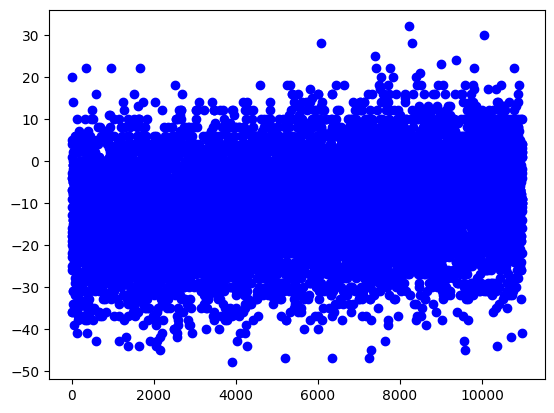

In [21]:
import matplotlib.pyplot as plt

x = list(range(len(env.all_rewards)))
y = env.all_rewards

plt.scatter(x, y, c ="blue")

plt.show()

In [22]:
len(env.all_rewards)

10985

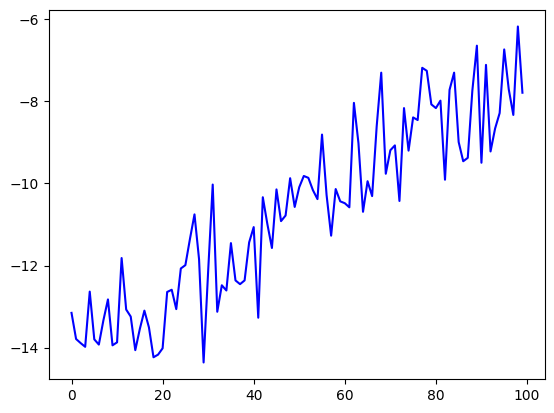

In [28]:
# Divide la lista en 100 sublistas
sublistas = np.array_split(env.all_rewards, 100)

# Calcula la media de cada sublista y guarda en una nueva lista
medias = [np.mean(sublista) for sublista in sublistas]

x = list(range(len(medias)))
y = medias

plt.plot(x, y, c ="blue")

plt.show()


In [55]:
print(env.all_rewards)

[-19, -20, -20, -19, -17, -18, -24, -20, -18, -22, -23, -24, -17, -24, -16, -19, -17, -16, -19, -23, -22, -16, -17, -18, -23, -21, -20, -20, -16, -17, -17, -21, -22, -20, -21, -20, -19, -16, -22, -22, -23, -18, -19, -16, -24, -19, -21, -22, -19, -18, -17, -18, -16, -17, -19, -17, -22, -17, -18, -16, -21, -18, -17, -23, -19, -18, -20, -19, -12, -21, -20, -20, -16, -17, -16, -21, -20, -17, -19, -17, -18, -19, -23, -16, -20, -20, -16, -19, -24, -18, -22, -22, -21, -20, -22, -19, -23, -22, -22, -20, -21, -22, -22, -17, -23, -23, -18, -16, -19, -24, -21, -22, -21, -19, -16, -17, -17, -1, -17, -23, -17, -19, -24, -21, -24, -24, -22, -17, -18, -20, -22, -17, -22, -18, -20, -20, -16, -23, -20, -16, -21, -23, -16, -17, -17, -21, -22, -23, -17, -24, -17, -16, -19, -22, -24, -19, -19, -20, -19, -20, -22, -16, -22, -18, -24, -22, -16, -18, -24, -19, -21, -23, -24, -20, -18, -22, -19, -22, -22, -18, -22, -20, -19, -16, -19, -24, -20, -21, -18, -21, -24, -19, -22, -17, -13, -18, -21, -18, -20, -18, 

In [29]:
# env = OrganizationEnvironment(rendering=True)
obs = env.reset()

while True:
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    print(reward)
    if done == True:
        break

	  Desafíos
Alumno 0:  [0, 0, 0, 0]
Alumno 1:  [0, 0, 0, 0]
Alumno 2:  [0, 0, 0, 0]
Alumno 3:  [0, 0, 0, 0]
Alumno 4:  [0, 0, 0, 0]
Alumno 5:  [0, 0, 0, 0]
Alumno 6:  [0, 0, 1, 0]
Alumno 7:  [0, 0, 0, 0]
Alumno 8:  [0, 0, 0, 0]
Alumno 9:  [0, 0, 0, 0]
2
	  Desafíos
Alumno 0:  [0, 0, 0, 0]
Alumno 1:  [0, 0, 0, 0]
Alumno 2:  [0, 0, 0, 0]
Alumno 3:  [0, 0, 0, 0]
Alumno 4:  [0, 0, 0, 0]
Alumno 5:  [0, 0, 0, 0]
Alumno 6:  [0, 0, 1, 0]
Alumno 7:  [0, 0, 1, 0]
Alumno 8:  [0, 0, 0, 0]
Alumno 9:  [0, 0, 0, 0]
2
	  Desafíos
Alumno 0:  [0, 0, 0, 0]
Alumno 1:  [0, 0, 0, 0]
Alumno 2:  [0, 0, 0, 0]
Alumno 3:  [0, 0, 0, 0]
Alumno 4:  [1, 0, 0, 0]
Alumno 5:  [0, 0, 0, 0]
Alumno 6:  [0, 0, 1, 0]
Alumno 7:  [0, 0, 1, 0]
Alumno 8:  [0, 0, 0, 0]
Alumno 9:  [0, 0, 0, 0]
-5
	  Desafíos
Alumno 0:  [0, 0, 0, 0]
Alumno 1:  [0, 0, 0, 0]
Alumno 2:  [0, 0, 0, 0]
Alumno 3:  [0, 0, 0, 0]
Alumno 4:  [1, 0, 0, 0]
Alumno 5:  [0, 0, 1, 0]
Alumno 6:  [0, 0, 1, 0]
Alumno 7:  [0, 0, 1, 0]
Alumno 8:  [0, 0, 0, 0]
Alumno 9: